# Fraudulent Claims Analysis
This analysis aims to answer research question 1, assess whether machine learning model are better at predicting survival than traditional statistical model. Survival analysis is a concept that is not only applied in the insurance sector, but also in health, biology, and also in the manufacturing industry. 

This analysis is divided into 2 part, prediction using the traditional model specifically the Cox PH model and prediction using machine learning models:
4 sections will be covers in this analysis.
1. Data Importing and Inspection
2. Data Preprocessing
3. Prediction and evalaution using the Cox PH model
4. Feature Engineering
5. Model Building and Evaluation



## Section 1: Data Importing and Inspection

### Importing the important libraries

In [1]:

%matplotlib inline



from sklearn.utils import resample,shuffle

from sksurv.nonparametric import kaplan_meier_estimator

from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis


from bokeh.palettes import Spectral10

# importing libraries
import warnings
warnings.filterwarnings("ignore")

# for data importing and manipulation
import pandas as pd   

# for data array and matrix manipulation
import numpy as np  

# for plotting data
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines.utils import concordance_index
from sklearn.metrics import precision_score, recall_score

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Lasso


from xgboost import XGBClassifier

# for encoding and standizing the data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# to handle imbalanced data
from imblearn.over_sampling import SMOTE

# to split the dataset into train and test set
from sklearn.model_selection import train_test_split

# for performing hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# models to be trained
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import lightgbm as lgb
from xgboost import XGBClassifier

# for model evaluation 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import statistics as sta
from scipy.stats import skew, kurtosis

from scipy.spatial.distance import cdist
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

from sksurv.metrics import concordance_index_censored


pd.set_option('display.max_columns', None)

### Reading the data
The aids data used is extracting from the sksurv.dataset library

In [2]:
from sksurv.datasets import load_aids

# reading the data from load_aids()
data_x, data_y = load_aids()
data_y

array([(False, 189.), (False, 287.), (False, 242.), ..., (False, 272.),
       (False, 192.), (False, 132.)],
      dtype=[('censor', '?'), ('time', '<f8')])

In [3]:
# printing the target variables
data_x

,age,cd4,hemophil,ivdrug,karnof,priorzdv,raceth,sex,strat2,tx,txgrp
0,34.0,169.0,0,1,100,39.0,1,1,1,0,1
1,34.0,149.5,0,1,90,15.0,2,2,1,0,1
2,20.0,23.5,1,1,100,9.0,1,1,0,1,2
3,48.0,46.0,0,1,90,53.0,1,1,1,0,1
4,46.0,10.0,0,3,90,12.0,1,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...
1146,44.0,65.5,0,1,100,103.0,1,1,1,1,2
1147,41.0,7.5,0,1,80,20.0,2,1,0,1,2
1148,43.0,170.0,0,3,90,27.0,2,1,1,0,1
1149,44.0,282.5,0,3,80,12.0,1,1,1,0,1


In [4]:
data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1151 non-null   float64 
 1   cd4       1151 non-null   float64 
 2   hemophil  1151 non-null   category
 3   ivdrug    1151 non-null   category
 4   karnof    1151 non-null   category
 5   priorzdv  1151 non-null   float64 
 6   raceth    1151 non-null   category
 7   sex       1151 non-null   category
 8   strat2    1151 non-null   category
 9   tx        1151 non-null   category
 10  txgrp     1151 non-null   category
dtypes: category(8), float64(3)
memory usage: 37.3 KB


In [5]:
# printing the description of the predictors
data_x.describe(include = "all")

,age,cd4,hemophil,ivdrug,karnof,priorzdv,raceth,sex,strat2,tx,txgrp
count,1151.000000,1151.000000,1151,1151,1151,1151.000000,1151,1151,1151,1151,1151
unique,NaN,NaN,2,3,4,NaN,5,2,2,2,4
top,NaN,NaN,0,1,90,NaN,1,1,1,0,1
freq,NaN,NaN,1116,968,541,NaN,596,951,712,577,576
mean,38.647263,86.459745,NaN,NaN,NaN,30.419157,NaN,NaN,NaN,NaN,NaN
std,8.811395,70.054330,NaN,NaN,NaN,29.217779,NaN,NaN,NaN,NaN,NaN
min,15.000000,0.000000,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN
25%,33.000000,23.000000,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN
50%,38.000000,74.500000,NaN,NaN,NaN,21.000000,NaN,NaN,NaN,NaN,NaN
75%,44.000000,136.500000,NaN,NaN,NaN,42.000000,NaN,NaN,NaN,NaN,NaN


An overview of the data shows that all the data types are in the right format and there are no null values (both implicit and explicit) hence there will be no preprocessing.

## Section 3: Feature Engineering

This section deals with transforming the features of the data to suit the task at hand. This section involved:
1. Encoding the categorical columns
2. Standardizing the numerical columns
3. Upsampling to ensure the different classes of the target variable have the same count.



#### Encoding the categorical variables

In [6]:
from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,age,cd4,hemophil=1,ivdrug=2,ivdrug=3,karnof=80,karnof=90,karnof=100,priorzdv,raceth=2,raceth=3,raceth=4,raceth=5,sex=2,strat2=1,tx=1,txgrp=2,txgrp=3,txgrp=4
0,34.0,169.0,0.0,0.0,0.0,0.0,0.0,1.0,39.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,34.0,149.5,0.0,0.0,0.0,0.0,1.0,0.0,15.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,20.0,23.5,1.0,0.0,0.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,48.0,46.0,0.0,0.0,0.0,0.0,1.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,46.0,10.0,0.0,0.0,1.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


#### Standardizing the numerical variables

In [7]:
data_x_numeric[['age', 'cd4', 'priorzdv']] = StandardScaler(with_mean=False).fit_transform(data_x_numeric[['age', 'cd4', 'priorzdv']])
data_x_numeric.head()

,age,cd4,hemophil=1,ivdrug=2,ivdrug=3,karnof=80,karnof=90,karnof=100,priorzdv,raceth=2,raceth=3,raceth=4,raceth=5,sex=2,strat2=1,tx=1,txgrp=2,txgrp=3,txgrp=4
0,3.860317,2.413462,0.0,0.0,0.0,0.0,0.0,1.0,1.335384,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.860317,2.134986,0.0,0.0,0.0,0.0,1.0,0.0,0.513609,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,2.270775,0.335600,1.0,0.0,0.0,0.0,0.0,1.0,0.308166,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,5.449859,0.656919,0.0,0.0,0.0,0.0,1.0,0.0,1.814753,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5.222782,0.142808,0.0,0.0,1.0,0.0,1.0,0.0,0.410887,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## Section 4: Model Building and Testing

This session involves creating models and checking the accuracies of the model to make predictions. In this section, the hyperparameters of five models will be tuned to give the best accuracy and the model with the highest accuracy will be finally used to make prediction.



### Splitting the data into train and test set

Before beginning these processes, the data is split into train and test set to prevent data leakage. The data predictors are first assigned to x_data and the target variable is assigned to y_data. These two datasets are then split using the sklearn's __train_test_split__ using a test_size of _20%_. 

This will randomly assign _20%_ of the values to the __testset__ and _80%_ of the values to the __trainset__.

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_x_numeric, data_y, test_size=0.2, random_state=25)

In [9]:
X_train

,age,cd4,hemophil=1,ivdrug=2,ivdrug=3,karnof=80,karnof=90,karnof=100,priorzdv,raceth=2,raceth=3,raceth=4,raceth=5,sex=2,strat2=1,tx=1,txgrp=2,txgrp=3,txgrp=4
945,6.812324,0.314178,0.0,0.0,0.0,1.0,0.0,0.0,0.205444,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
568,6.812324,0.042843,0.0,0.0,0.0,0.0,1.0,0.0,4.656723,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
994,3.746778,0.963957,0.0,0.0,0.0,1.0,0.0,0.0,0.205444,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
150,2.952007,0.706902,1.0,0.0,0.0,0.0,1.0,0.0,2.191399,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
211,3.179085,1.285276,1.0,0.0,0.0,0.0,0.0,1.0,0.616331,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,5.790476,0.714042,0.0,0.0,0.0,0.0,1.0,0.0,1.335384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
886,5.336321,1.349539,0.0,0.0,0.0,0.0,0.0,1.0,0.821775,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,5.563398,2.363479,0.0,0.0,0.0,0.0,1.0,0.0,1.369625,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
474,4.428011,0.149949,0.0,0.0,0.0,0.0,1.0,0.0,0.239684,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# displays text representation of estimators
set_config(display="text")

# instatiating the model
estimator = CoxPHSurvivalAnalysis()

# fitting the model
estimator.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

In [11]:
# covariate importance
pd.Series(estimator.coef_, index=X_train.columns)

age            0.291844
cd4           -1.167964
hemophil=1     0.240884
ivdrug=2       0.644733
ivdrug=3      -0.411157
karnof=80     -0.640566
karnof=90     -1.195779
karnof=100    -1.596708
priorzdv      -0.020449
raceth=2      -0.342991
raceth=3       0.203449
raceth=4       0.839236
raceth=5       0.215923
sex=2          0.335616
strat2=1       0.023888
tx=1          -0.264290
txgrp=2       -0.352643
txgrp=3      -14.148402
txgrp=4      -12.967937
dtype: float64

In [12]:
# evaluating the Cox ph model using the concordance index
prediction = estimator.predict(X_test)

# finding the performance of the model on the test data
result = concordance_index_censored(y_test["censor"], y_test["time"], prediction)
result[0]

0.7213462704669497

In [13]:
# displaying the prediction of the Cox model
prediction

array([-4.28916213, -0.76798503, -0.28186342, -0.00993442, -0.71995042,
       -2.03492805, -1.80852621, -1.06884628, -0.82635403, -1.58725143,
       -0.55294712, -2.19680873, -4.63966939, -1.16829264,  0.12056866,
       -1.68513983, -3.94504806,  0.68282786, -4.82075833, -0.34285607,
        0.29072149, -2.9819994 ,  0.17671363, -0.38767795, -4.29023429,
        0.16243234, -2.6389827 , -0.15248262,  0.71123741, -2.58347967,
        0.09525895, -0.74779146, -1.16601182, -0.09476406, -0.56692677,
        1.13588545, -2.08423347, -5.19445539, -0.85757401, -3.84016822,
       -2.50490102, -0.96549578, -4.050636  , -1.87995749, -2.62419816,
       -3.80822209, -2.37637423, -3.59137357, -1.71691056, -0.76279144,
       -1.27228356, -0.82488528, -2.55861771, -0.18849429, -2.40300634,
       -3.50495061, -2.71442322, -3.25207908, -2.0411399 , -1.22992311,
       -1.15837531, -2.63017731, -1.44482828, -1.82818806, -2.00424268,
       -2.90010749, -2.88204939, -2.74950976,  0.02594817, -1.37

### Illustrating the Kaplan Meier Estimator

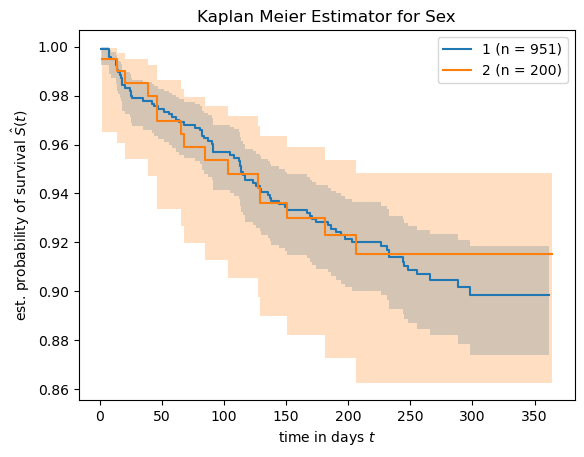

In [14]:
# Kaplan Meier Estimator on the Sex variable
for value in data_x["sex"].unique():
    mask = data_x["sex"] == value
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        data_y["censor"][mask], 
        data_y["time"][mask], 
        conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"{value} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

# plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time in days $t$")
plt.legend(loc="best")
plt.title("Kaplan Meier Estimator for Sex")
plt.show()

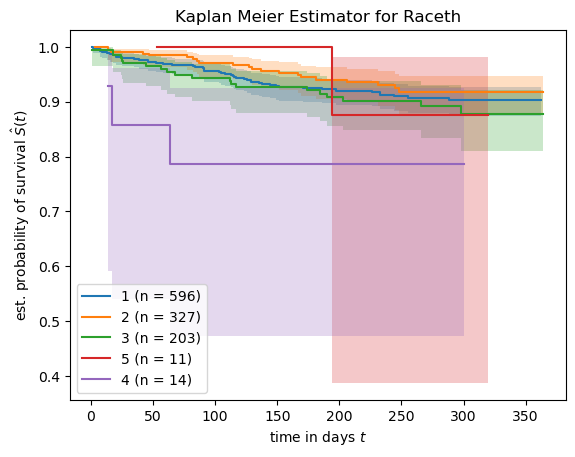

In [15]:
# Kaplan Meier Estimator on the Raceth variable
for value in data_x["raceth"].unique():
    mask = data_x["raceth"] == value
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        data_y["censor"][mask], 
        data_y["time"][mask], 
        conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"{value} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

# plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time in days $t$")
plt.legend(loc="best")
plt.title("Kaplan Meier Estimator for Raceth")
plt.show()

# Machine Learning
In this section machine learning models will be trained on the data and the performances will be evaluated. For this to be done the data has to be transformed into a suitable format.

## Data Transformation

In [16]:
# Separate the boolean values and float values into two lists
boolean_values = [item[0] for item in data_y]
float_values = [item[1] for item in data_y]

# Convert the lists to numpy arrays if needed
boolean_values_array = np.array(boolean_values)
float_values_array = np.array(float_values)

# Creating a Pandas DataFrame
dataf_y = pd.DataFrame({'Status': boolean_values, 'Survival_in_Days': float_values})

# Print the first few rows of the DataFrame
print(dataf_y.head())

   Status  Survival_in_Days
0   False             189.0
1   False             287.0
2   False             242.0
3   False             199.0
4   False             286.0


In [17]:
# creating a single dataset with both predictors and target variables
df = pd.concat([data_x, dataf_y], axis=1)

In [18]:
# printing the dataset
df.head(10)

,age,cd4,hemophil,ivdrug,karnof,priorzdv,raceth,sex,strat2,tx,txgrp,Status,Survival_in_Days
0,34.0,169.0,0,1,100,39.0,1,1,1,0,1,False,189.0
1,34.0,149.5,0,1,90,15.0,2,2,1,0,1,False,287.0
2,20.0,23.5,1,1,100,9.0,1,1,0,1,2,False,242.0
3,48.0,46.0,0,1,90,53.0,1,1,1,0,1,False,199.0
4,46.0,10.0,0,3,90,12.0,1,1,0,1,2,False,286.0
5,51.0,0.0,0,1,70,24.0,1,1,0,1,2,False,285.0
6,51.0,54.5,0,1,100,6.0,2,1,1,0,1,False,270.0
7,40.0,117.5,0,3,80,24.0,2,1,1,1,2,False,285.0
8,34.0,95.0,0,1,100,7.0,1,1,1,0,1,False,276.0
9,38.0,71.0,0,1,90,7.0,1,1,1,0,1,False,306.0


In [19]:
# printing the information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               1151 non-null   float64 
 1   cd4               1151 non-null   float64 
 2   hemophil          1151 non-null   category
 3   ivdrug            1151 non-null   category
 4   karnof            1151 non-null   category
 5   priorzdv          1151 non-null   float64 
 6   raceth            1151 non-null   category
 7   sex               1151 non-null   category
 8   strat2            1151 non-null   category
 9   tx                1151 non-null   category
 10  txgrp             1151 non-null   category
 11  Status            1151 non-null   bool    
 12  Survival_in_Days  1151 non-null   float64 
dtypes: bool(1), category(8), float64(4)
memory usage: 47.4 KB


Number of each class:


False    1055
True       96
Name: Status, dtype: int64

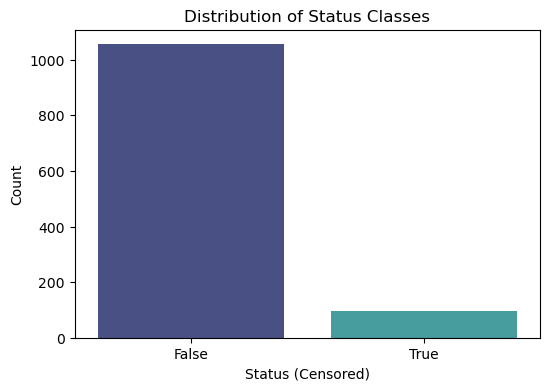

In [20]:
# "# finding the different classes of sentiments of the data
sent_count = df['Status'].value_counts()
print('Number of each class:')
display(sent_count)

# Plot the distribution of the 'Response' column
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Status', order=df['Status'].value_counts().index, palette='mako')
plt.title('Distribution of Status Classes')
plt.ylabel('Count')
plt.xlabel('Status (Censored)')
plt.show()

### Splitting the data into train and test set

Before beginning these processes, the data is split into train and test set to prevent data leakage. The data predictors are first assigned to x_data and the target variable is assigned to y_data. These two datasets are then split using the sklearn's __train_test_split__ using a test_size of ___20%___. 

This will randomly assign _20%_ of the values to the __testset__ and _80%_ of the values to the __trainset__.

The datasets were varied in four ways. The first way consisted of the the Status used as the target variable without the Clusters as a predictor and in the second way, as a predictor. The third way involved using the Clusters as the target without the Status as a variable and the last way involved using it as a predictor. 

In [21]:
# Seperating the predictors and the predictor
X = df.drop(['Status'], axis=1)
y = df['Status']
y_status = df['Status']
y_survival = df['Survival_in_Days']

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, y_survival_train, y_survival_test = train_test_split(X, y, y_survival, test_size=0.2, random_state=25)

# printing the shapes of the train and test data
print("X train dataset has a size:", X_train.shape)
print("Y train dataset has a size:", y_train.shape)
print("Y train dataset has a size:", y_survival_train.shape)
print("X test dataset has a size:", X_test.shape)
print("Y test dataset has a size:", y_test.shape)
print("Y train dataset has a size:", y_survival_test.shape)

X train dataset has a size: (920, 12)
Y train dataset has a size: (920,)
Y train dataset has a size: (920,)
X test dataset has a size: (231, 12)
Y test dataset has a size: (231,)
Y train dataset has a size: (231,)


In [23]:
# printing the x train set
X_train.head()

,age,cd4,hemophil,ivdrug,karnof,priorzdv,raceth,sex,strat2,tx,txgrp,Survival_in_Days
945,60.0,22.0,0,1,80,6.0,3,1,0,0,1,264.0
568,60.0,3.0,0,1,90,136.0,1,1,0,1,2,321.0
994,33.0,67.5,0,1,80,6.0,1,1,1,0,1,235.0
150,26.0,49.5,1,1,90,64.0,1,2,1,0,1,322.0
211,28.0,90.0,1,1,100,18.0,1,1,1,1,2,161.0


In [24]:
# printing the y train set
y_train.head()

945    False
568    False
994    False
150    False
211    False
Name: Status, dtype: bool

## Transforming the data into by Scaling the numerical values and encoding the categorical variables

In [25]:
# The scalers, encoders and the columns to scale and encode are passed as parameters into the column transformer 
# creating a column transformer object
transformer = ColumnTransformer([
    ('scaler', StandardScaler(with_mean=False), ['age', 'cd4', 'priorzdv', 'Survival_in_Days']),
    ('one_hot', OneHotEncoder(), ['hemophil', 'ivdrug', 'karnof', 'raceth', 'sex', 'strat2', 'tx',
       'txgrp'])
                                                ])

In [26]:
# fitting the transformer on the train set
transformer.fit(X_train)

ColumnTransformer(transformers=[('scaler', StandardScaler(with_mean=False),
                                 ['age', 'cd4', 'priorzdv',
                                  'Survival_in_Days']),
                                ('one_hot', OneHotEncoder(),
                                 ['hemophil', 'ivdrug', 'karnof', 'raceth',
                                  'sex', 'strat2', 'tx', 'txgrp'])])

In [27]:
# transforming both the train and test set
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [28]:
# further creating the x_train data
y_survival_train = pd.Series(y_survival_train).values

# Converting the train data into a dataframe
X_train = pd.DataFrame(X_train)

# add the survival in days to the train set since it shouldn't be scaled
X_train['Surv_Days'] = pd.DataFrame(y_survival_train)

In [29]:
# printing the dataframe
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Surv_Days
0,6.728830,0.311797,0.224341,2.926926,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,264.0
1,6.728830,0.042518,5.085058,3.558875,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,321.0
2,3.700857,0.956651,0.224341,2.605407,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,235.0
3,2.915826,0.701544,2.392969,3.569962,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,322.0
4,3.140121,1.275535,0.673022,1.784981,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,161.0


In [30]:
# dropping the third column since it is not needed
# X_train.drop('3', axis=1, inplace = True)

In [31]:
# printing the information of the train set
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   0          920 non-null    float64
 1   1          920 non-null    float64
 2   2          920 non-null    float64
 3   3          920 non-null    float64
 4   4          920 non-null    float64
 5   5          920 non-null    float64
 6   6          920 non-null    float64
 7   7          920 non-null    float64
 8   8          920 non-null    float64
 9   9          920 non-null    float64
 10  10         920 non-null    float64
 11  11         920 non-null    float64
 12  12         920 non-null    float64
 13  13         920 non-null    float64
 14  14         920 non-null    float64
 15  15         920 non-null    float64
 16  16         920 non-null    float64
 17  17         920 non-null    float64
 18  18         920 non-null    float64
 19  19         920 non-null    float64
 20  Surv_Days 

## Handling Imbalanced Data

Imbalanced data occurs when the distribution of classes is uneven. The class with the highest count in the target class is termed the majority class and the other class or classes are termed the minority class.
Imbalanced data can cause machine learning models to have lower accuracy, as they may be biased towards the majority class and fail to properly classify the minority class.

### Using the Synthetic Minority Over-sampling Technique (SMOTE) to handle the imbalanced dataset

The SMOTE technique creates synthetic data of the minority class to balance the majority class. 

__NOTE__: Introducing synthetic data also introducing some sort of bias into the dataset that will be used to train the model.

Correcting an imbalance in the count of the classes of the target variable prevents the model from learning too much form the majority class and assume that it has a higher significance, and being baised towards the class with a few values. 


In [32]:
# converting the column names into from integers to strings
X_train.columns = X_train.columns.astype(str)

In [33]:
# creating the SMOTE instance where the five closest neighbors to a point are used to generate a new point
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=25)

# fitting and resampling the dataset to create new synthetic datapoints
X_train, y_train = smote.fit_resample(X_train, y_train)

In [34]:
# printing the shape of the new train data
print("X train dataset has a size after upsampling: ",X_train.shape)
print("Y train dataset has a size after upsampling: ",y_train.shape)

X train dataset has a size after upsampling:  (1682, 21)
Y train dataset has a size after upsampling:  (1682,)


In [35]:
# # checkinig the counts of the classes of the target variable
print("Value count of classes of the target variable\n", y_train.value_counts())

Value count of classes of the target variable
 False    841
True     841
Name: Status, dtype: int64


In [36]:
# extracting the predictors and predictor again after upsampling
y_surv_days = X_train['Surv_Days'].astype(int)
X_train.drop('Surv_Days', axis = 1, inplace = True)

y_status_train = y_train
y_status_test = y_test

In [37]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,6.728830,0.311797,0.224341,2.926926,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.728830,0.042518,5.085058,3.558875,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,3.700857,0.956651,0.224341,2.605407,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2.915826,0.701544,2.392969,3.569962,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,3.140121,1.275535,0.673022,1.784981,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [38]:
pd.DataFrame(X_test).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3.252268,3.458117,0.448682,1.474550,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.925151,0.347229,0.224341,2.394757,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.813004,0.177158,0.224341,1.274987,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.046623,0.240934,1.159094,3.703004,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.719506,0.687372,0.224341,2.849318,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Training and Testing machine learning models

A function is created to fit the data on 6 machine learning models. The model evaluation metrics are calculated. Their regression models are also trained on the data and their performances are also measured. 

In [39]:
# Define a dictionary of models
models = {
    "Random Forest Classifier": RandomForestClassifier(random_state=25),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=25),
    "SVC": SVC(random_state=25),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=25),
    "XGBoost": XGBClassifier(random_state=25),
    "LightGBM": lgb.LGBMClassifier(random_state=25)
}

# Train and evaluate each model for "Status" and "Survival_in_Days"
for model_name, model in models.items():
    model.fit(X_train, y_status_train)
    y_status_pred = model.predict(X_test)
    
    # Evaluation for "Status"
    accuracy = accuracy_score(y_status_test, y_status_pred)
    f1 = f1_score(y_status_test, y_status_pred)
    # Calculate precision
    precision = precision_score(y_status_test, y_status_pred)

    # Calculate recall
    recall = recall_score(y_status_test, y_status_pred)
    # Check if the model supports regression (not Lasso and SVC)
    if model_name not in ["XGBoost", "LightGBM"]:
        model.fit(X_train, y_surv_days)
        y_survival_pred = model.predict(X_test)

        # Evaluation for "Survival_in_Days using the mean squared error and mean absolute error"
        mse = mean_squared_error(y_survival_test, y_survival_pred)
        mae = mean_absolute_error(y_survival_test, y_survival_pred)
        c_index = concordance_index(y_survival_test, -y_survival_pred)

        print(f"\nModel: {model_name} (for Survival_in_Days)")
        print(f"Mean Squared Error: {mse:.5f}")
        print(f"Mean Absolute Error: {mae:.5f}")
    
    # Printing model evaluation metrics
    print(f"\nModel: {model_name} (for Status)")
    print(f"Accuracy: {accuracy:.5f}")
    print(f"F1-Score: {f1:.5f}")
    print(f'Precision: {precision:.5f}')
    print(f'Recall: {recall:.5f}')
    
    print("-"*50)


Model: Random Forest Classifier (for Survival_in_Days)
Mean Squared Error: 4228.43723
Mean Absolute Error: 41.37229

Model: Random Forest Classifier (for Status)
Accuracy: 0.93074
F1-Score: 0.46667
Precision: 0.53846
Recall: 0.41176
--------------------------------------------------

Model: Gradient Boosting Classifier (for Survival_in_Days)
Mean Squared Error: 7715.36364
Mean Absolute Error: 67.85714

Model: Gradient Boosting Classifier (for Status)
Accuracy: 0.92208
F1-Score: 0.47059
Precision: 0.47059
Recall: 0.47059
--------------------------------------------------

Model: SVC (for Survival_in_Days)
Mean Squared Error: 2080.85281
Mean Absolute Error: 36.46320

Model: SVC (for Status)
Accuracy: 0.86147
F1-Score: 0.38462
Precision: 0.28571
Recall: 0.58824
--------------------------------------------------

Model: Decision Tree Classifier (for Survival_in_Days)
Mean Squared Error: 0.79654
Mean Absolute Error: 0.20779

Model: Decision Tree Classifier (for Status)
Accuracy: 0.89177
F1